In [2]:

import pymdp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import scipy.stats as stats
import copy
import time
import random

# This notebook
This simulates a single run of POMDP with more complicated generative model. Tumor states are noised, it has to make decisions whether to test, and testing and treating come with cost. Tumor states no longer have cost, only patient death has cost. 

In [3]:

#completely taken from PYMDP tutorials
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

#make a functio that generates
def plot_simulation_outcome(df):
        #plot the tumor state and resistance state
        plt.plot(df['tumor_state'], label = 'Tumor level')
        plt.plot(df['resistance_state'], label = 'Resistance level', linestyle = '--')

        #shade in when treatment is on
        for i in range(len(df)):
            if df['treatment_state'][i] == 'treat':
                plt.fill_between(x = [i, i+1], y1 = 0, y2 = 6, color = 'gray', alpha = 0.5)

        #show the labels
        plt.legend()
        plt.show()


## Changed functions
Expected states to factor in extra dimensions in B-tensor.

In [4]:
def get_expected_states(qs, B, policy):
    """
    Compute the expected states under a policy, also known as the posterior predictive density over states

    Parameters
    ----------
    qs: ``numpy.ndarray`` of dtype object
        Marginal posterior beliefs over hidden states at a given timepoint.
    B: ``numpy.ndarray`` of dtype object
        Dynamics likelihood mapping or 'transition model', mapping from hidden states at ``t`` to hidden states at ``t+1``, given some control state ``u``.
        Each element ``B[f]`` of this object array stores a 3-D tensor for hidden state factor ``f``, whose entries ``B[f][s, v, u]`` store the probability
        of hidden state level ``s`` at the current time, given hidden state level ``v`` and action ``u`` at the previous time.
    policy: 2D ``numpy.ndarray``
        Array that stores actions entailed by a policy over time. Shape is ``(num_timesteps, num_factors)`` where ``num_timesteps`` is the temporal
        depth of the policy and ``num_factors`` is the number of control factors.

    Returns
    -------
    qs_pi: ``list`` of ``numpy.ndarray`` of dtype object
        Predictive posterior beliefs over hidden states expected under the policy, where ``qs_pi[t]`` stores the beliefs about
        hidden states expected under the policy at time ``t``
    """
    n_steps = policy.shape[0]
    n_factors = policy.shape[1]

    # initialise posterior predictive density as a list of beliefs over time, including current posterior beliefs about hidden states as the first element
    qs_pi = [qs] + [pymdp.utils.obj_array(n_factors) for t in range(n_steps)]
    
    # get expected states over time
    for t in range(n_steps):

        for control_factor, action in enumerate(policy[t,:]):
            
            #figure out which B matrix to use
            collapse_workflows = collapse_list[control_factor]
            
            #Get all slices for the chosen action
            B_factor = B[control_factor][...,int(action)]
            if len(collapse_workflows) > 0:

                #for each collapse which is a (factor and timeoffset), 
                for workflow in collapse_workflows:
                    #get timesteps of belief and what state to collapse by
                    factor, time_offset = workflow

                    #Get the dot.product to collapse the b
                    B_factor = B_factor.dot(qs_pi[t+time_offset+1][factor])

            #calculate expected posterior of the state for the timestep given the action
            qs_pi[t+1][control_factor] = B_factor.dot(qs_pi[t][control_factor])

    #Return a list of expected states given the policy
    return qs_pi[1:]

pymdp.control.get_expected_states = get_expected_states

#def a function to add noise to the observation
def add_noise(o, noise_sd):
    o = (round(o[0] + np.random.normal(0, noise_sd)), o[1])
    if o[0] < 0:
        o = (0, o[1])
    elif o[0] > len(tumor_names) - 1:
        o = (5, o[1])

    return o

# Simulation settings

In [5]:
#define names tumor names
tumor_names = ['t1', 't2', 't3', 't4', 't5', 't6']

#the same for resistances
resistance_names = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6']

#treatment names
treatment_names = ['no treatment', 'treatment']

#patient state names
patient_names = ["alive", "dead"]

#testing names
testing_names = ["not testing", 'testing']

#define the state factor array 
factor_names = [tumor_names, resistance_names, treatment_names, patient_names, testing_names]


num_states = [len(tumor_names), len(resistance_names), len(treatment_names), len(patient_names), len(testing_names)]
num_factors = len(num_states)

#no possible action for tumor and resistance factor
tumor_action_names = ['Do nothing']
resistance_action_names = ['Do nothing']
patient_action_names = ['Do nothing']

#can decide to treat or not
treatment_action_names = ['dont treat', 'treat']

#decide on testing too
testing_action_names = ["dont test", "test"]
                      
#Define number of control states
num_controls = [len(tumor_action_names), len(resistance_action_names), len(treatment_action_names)]

#Define observation states + a no observation for tumor reading
tumor_observation_names = tumor_names + ["no observation"]
treatment_observation_names = treatment_names
patient_observation_names = patient_names
testing_observation_names = testing_names

#only tumor level is and treatment are observable, but others could be added.
num_observations = [len(tumor_observation_names), len(treatment_observation_names), len(patient_observation_names), len(testing_observation_names)]

num_modalities = len(num_observations)

#collapse tumor by resistance, t-1 beliefs
collapse_list_tumor = [(1, -1)]

#collapse resistance by tumor, t0 beliefs
collapse_list_resistance = [(0, 0)]

#collapse by whether beliefs about tumor at t-1
collapse_list_patient = [(0, -1)]

#make a list of collapsing workflows ordered by factor
collapse_list = [collapse_list_tumor, collapse_list_resistance, [], collapse_list_patient, []]


#set seed
random.seed(3)


In [6]:
#sim settings
tumor_increase_prob = 0.3
resistance_increase_prob = 0.5 
treatment_effect_probs = [1, .8, .6, .5, .4, .2]
resistance_decrease_probs = [.0, .2, .4, .7, .8, .9]
tumor_starting_state = 0 
resistance_starting_state = 0
treatment_starting_state = 0
max_timesteps = 200
noise_sd = 1.0

## Code likelihoods
#simulate noise around observations first

In [7]:
int_list = []
noise_list = []
for i in range(100000):
    integer = random.choice(range(len(tumor_names)))

    o = (integer, 0)

    o = add_noise(o, noise_sd)

    int_list.append(integer)

    noise_list.append(o[0])

noise_df = pd.DataFrame({'int': int_list, 'noise': noise_list})


Use the results to inform the a matrix 

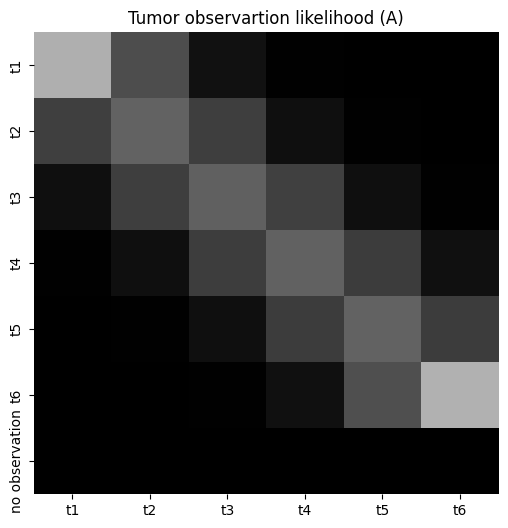

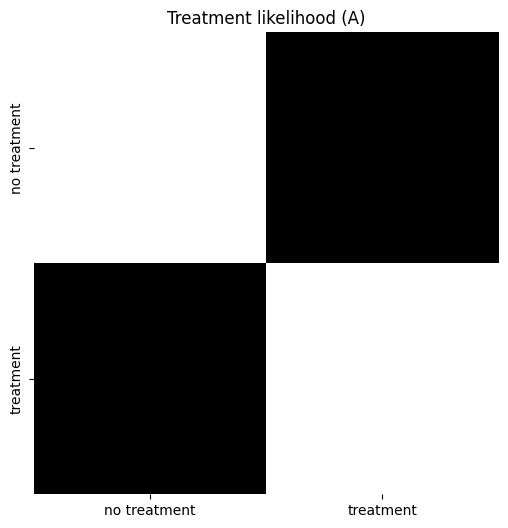

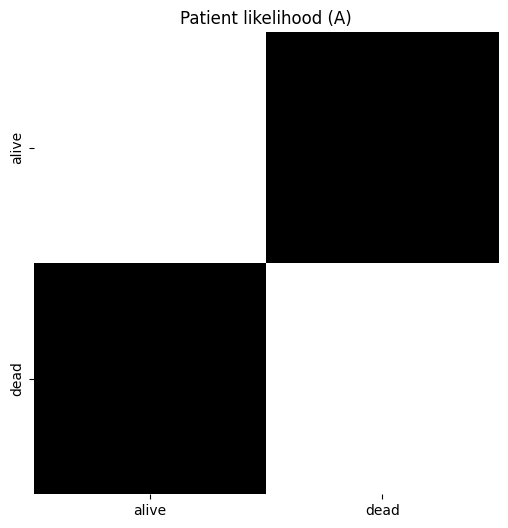

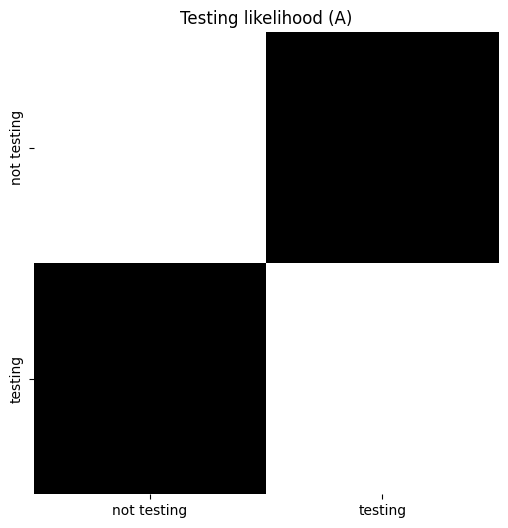

In [8]:
#Create A likelihood matrix per modality. Since there are only two observable outcomes, tumor level and treatment, there will be two likelihood arrays
#Create an empty array to store the likelihoods
A = pymdp.utils.obj_array( num_modalities )

#Create a likelihood matrix for the tumor modality
A_tumor = np.zeros((len(tumor_observation_names), len(tumor_names), len(resistance_names), len(treatment_names), len(patient_names), len(testing_names)))
                   
#Fill in the likelihood matrix for the tumor modality, with perfect observation of the tumor level
for i in range(len(tumor_observation_names)):
    for j in range(len(tumor_names)):     
        #if on the diagonal, the observation is correct and if we are testing
        #tumor_obs, tumor_state, res_state, treatment_state, patient_state, testing_state

            # if testing then
            A_tumor[i, j, :, :, :, 1] = sum(noise_df[noise_df['int'] == j]['noise'] == i) / len(noise_df[noise_df['int'] == j])

#when not testing
A_tumor[-1, :, :, :, :, 0] = 1

#Store the likelihood matrix for the tumor modality in the likelihood array
A[0] = A_tumor

#Create a likelihood matrix for the treatment modality
A_treatment = np.zeros((len(treatment_observation_names), len(tumor_names), len(resistance_names), len(treatment_names), len(patient_names), len(testing_names)))

#Fill in the likelihood matrix for the treatment modality, with perfect observation of the treatment
for i in range(len(treatment_observation_names)):
    for j in range(len(treatment_names)):     
        #if on the diagonal, the observation is correct
        if i == j:
            A_treatment[i, :, :, j, :, :] = 1.0

#store the treatment likelihoods
A[1] = A_treatment

#add an array for the patient modality
A_patient = np.zeros((len(patient_observation_names), len(tumor_names), len(resistance_names), len(treatment_names), len(patient_names), len(testing_names)))
for obs in range(len(patient_observation_names)):
    for state in range(len(patient_names)):
        if obs == state:
            A_patient[obs, :, :, :, state, :] = 1.0

A[2] = A_patient

#Create a likelihood matrix for the testing modality
A_testing = np.zeros((len(testing_observation_names), len(tumor_names), len(resistance_names), len(treatment_names), len(patient_names), len(testing_names)))
for obs in range(len(testing_observation_names)):
    for state in range(len(testing_names)):
        if obs == state:
            A_testing[obs, :, :, :, :, state] = 1.0

A[3] = A_testing

#Plot the likelihood matrix for the tumor modality to check. Pick the first state of the resistance factor, not treatment, and testing
plot_likelihood(A_tumor[:, :, 3, 0, 0, 1], xlabels = tumor_names, ylabels = tumor_observation_names, title_str = "Tumor observartion likelihood (A)")

#For treatments 
plot_likelihood(A_treatment[:, 1, 2, :, 0, 0], xlabels = treatment_names, ylabels = treatment_observation_names, title_str = "Treatment likelihood (A)")

#For patient
plot_likelihood(A_patient[:, 1, 1, 1, :, 0], xlabels = patient_names, ylabels = patient_observation_names, title_str = "Patient likelihood (A)")

#plot testing
plot_likelihood(A_testing[:, 1, 1, 1, 0, :], xlabels = testing_names, ylabels = testing_observation_names, title_str = "Testing likelihood (A)")



## Transition probabilities
Make a transition probability matrix for each state factor. Means that $B[0]$ correpsonds to tumor transition probabilities, and that $B[1]$ to resistance transition probabilties.

In [9]:
#Set the number of sub-arrays equal to number of factors
B = pymdp.utils.obj_array(num_factors) 

#Create B_tumor for tumor factor
B_tumor = np.zeros( (len(tumor_names), len(tumor_names), len(resistance_names), len(treatment_names)))

#fill in no treatment cancer progression. 
#rows correspond to the next state, columns to the current state. If treatment equals no treatment, the risk of tumor progression is simply the risk of tumor progression. #iterate through all resistance states and set one below the diagonal to the risk of tumor progression
for i in range(len(resistance_names)):

    #fill the diagonal with 1 - tumor_increase_prob
    np.fill_diagonal(B_tumor[:, :, i, 0], 1 - tumor_increase_prob)

    #fill the one below the diagonal with tumor_increase_prob
    np.fill_diagonal(B_tumor[1:, :, i, 0], tumor_increase_prob)

    #if tumor is at the top level, it can't increase anymore
    B_tumor[-1, 5, i, 0] = 1.0


#fill in treatment cancer progression. during treatment the chance of tumor progression depends on the resistance level.
for i in range(len(resistance_names)):

    #find the chance of treatment working given the resistance level
    treatment_succeeds = treatment_effect_probs[i]

    #the chance of reduction is the both the chance of progression doesn't happen and that treatment succeeds
    chance_of_reduction = treatment_succeeds * (1 - tumor_increase_prob)

    #chance of no reduction is the chance of progression happening and treatment succeding or treatment failing and progression not happening
    chance_of_no_change =  treatment_succeeds * tumor_increase_prob + (1 - treatment_succeeds) * (1 - tumor_increase_prob)

    #chance of increase in tumor is the chance of treatment failing and progression happening
    chance_of_increase = (1 - treatment_succeeds) * tumor_increase_prob

    #fill in transition probs for treatment working given the resistance level
    np.fill_diagonal(B_tumor[:, 1:, i, 1], chance_of_reduction)
    np.fill_diagonal(B_tumor[:, :, i, 1], chance_of_no_change)
    np.fill_diagonal(B_tumor[1:, :, i, 1], chance_of_increase)

    #if the tumor is at minimal state, it treatment isn't applied and it therefore can't be reduced any more. The chance of staying is therefore whatever is left after the risk of increasing and treatment failing. This is equal to tumor not progressing or tumor progressing and treatment working.
    B_tumor[0,0,i,1] = 1 - chance_of_increase

    #if the tumor is at maximal state, it can't increase anymore, the chance of staying is therefore everything except for reduction
    B_tumor[-1, -1, i, 1] = 1 - chance_of_reduction

#initialize the B_treatment matrix
B_resistance = np.zeros((len(resistance_names), len(resistance_names), len(tumor_names), len(treatment_names)))

#fill in no treatment resistance progression. Diagonal is chance of resistance not increasing, one below diagonal is chance of resistance increasing, and one above diaganol is chance of resistance decreasing
for i in range(len(tumor_names)):

    #Find the chance of resistance decreasing given the tumor level
    resistance_decrease_prob = resistance_decrease_probs[i]

    #chance of reducing the resistance level depends on the tumor level
    chance_of_reduction_no_treatment = resistance_decrease_prob

    #Probability of of no change can only happen if the resistance isn't reduced when treatment isn't given. 
    chance_of_no_change_no_treatment = 1 - chance_of_reduction_no_treatment

    #fill in transition probs for no treatment
    np.fill_diagonal(B_resistance[:, 1:, i, 0], chance_of_reduction_no_treatment)
    np.fill_diagonal(B_resistance[:, :, i, 0], chance_of_no_change_no_treatment)

    #when treatment is off and resistance is at lowest level, resistance can't decrease anymore
    B_resistance[0, 0, i, 0] = 1.0

    #The risk of progressing in resistance
    chance_of_increase_treatment = resistance_increase_prob

    #chance of reduction is the chance of resistance not increasing
    chance_of_no_change_treatment = (1 - resistance_increase_prob)

    #fill in transition probs for treatment
    #np.fill_diagonal(B_resistance[:, 1:, i, 1], chance_of_reduction_treatment)
    np.fill_diagonal(B_resistance[:, :, i, 1], chance_of_no_change_treatment)
    np.fill_diagonal(B_resistance[1:, :, i, 1], chance_of_increase_treatment)

    #when treatment is on and resistance is at its highest level, resistance can't increase anymore, instead it just stays at same level since treatment is applied
    B_resistance[-1, -1, i, 1] = 1.0

#fill in TPMs for deciding to treat. This always is perfect probability of choosing the treatment transitions into treatment
B_treatment = np.zeros((len(treatment_names), len(treatment_names), len(treatment_action_names)))

#setup matrix for controlling treatment. Treatment is always perfectly applied
for i in range(len(treatment_names)):
    B_treatment[i,:,i] = 1 


## Setup patient state TPMs
B_patient = np.zeros((len(patient_names), len(patient_names), len(tumor_names), len(patient_action_names)))

for tumor_level in range(len(tumor_names)):
    #if not in max tumor state, the patient remains in the same state
    if tumor_level != len(tumor_names) - 1:
        np.fill_diagonal(B_patient[:, :, tumor_level, 0], 1.0)
    
    #if in max tumor state, the patient dies
    else:
        B_patient[1, :, len(tumor_names) - 1, 0] = 1.0


#Setup testing TPM
#fill in TPMs for deciding to treat. This always is perfect probability of choosing the treatment transitions into treatment
B_testing = np.zeros((len(testing_names), len(testing_names), len(testing_action_names)))

#setup matrix for controlling treatment. Treatment is always perfectly applied
for i in range(len(testing_names)):
    B_testing[i,:,i] = 1 


#save the matricies to the B array
B[0] = B_tumor
B[1] = B_resistance
B[2] = B_treatment
B[3] = B_patient
B[4] = B_testing

## Setup C prior Dist Preferences

One C-matrix per outcome-modality, where rows correspond to level and columns correspond to timepoints.


Should it have temporal discounting? PYMDP looks different to matalb. Setting the probability of an outcome equal to the 100-timepoint and then softmaxing could probably do it.

Perhaps make these emperically based on adapative protocol or random treatment behavior.



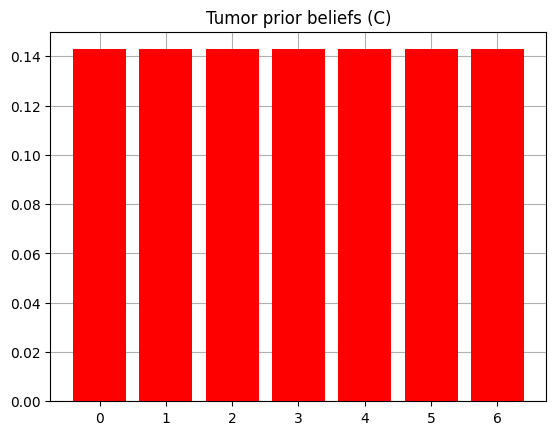

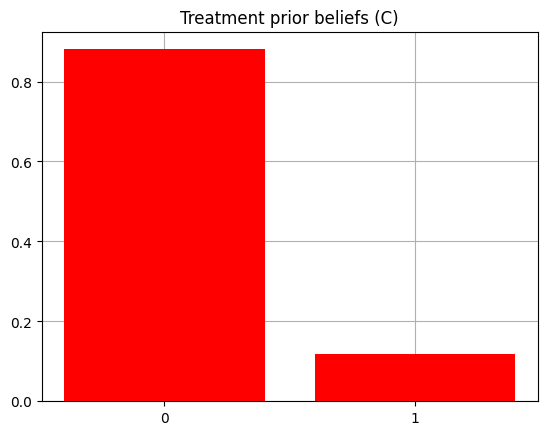

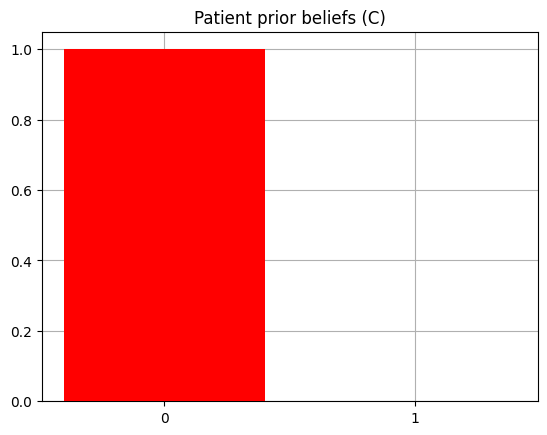

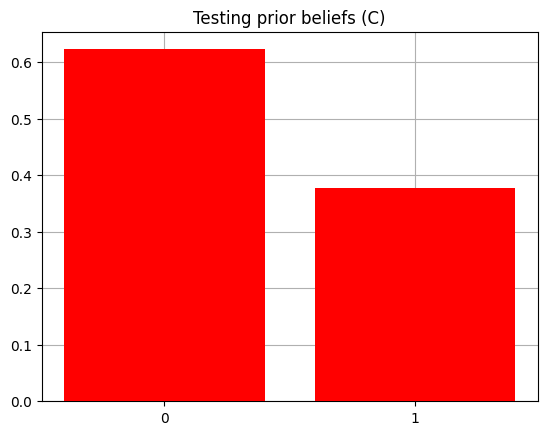

In [10]:
C = pymdp.utils.obj_array(num_modalities)

C_tumor = np.zeros(len(tumor_observation_names))
C_treatment = np.array([0, -2])
C_patient = np.array([0, -30])
C_testing = np.array([0, -.5])


C[0] = C_tumor
C[1] = C_treatment
C[2] = C_patient
C[3] = C_testing

plot_beliefs(pymdp.maths.softmax(C_tumor), title_str = "Tumor prior beliefs (C)")
plot_beliefs(pymdp.maths.softmax(C_treatment), title_str = "Treatment prior beliefs (C)")
plot_beliefs(pymdp.maths.softmax(C_patient), title_str = "Patient prior beliefs (C)")
plot_beliefs(pymdp.maths.softmax(C_testing), title_str = "Testing prior beliefs (C)")

## Setup prior beliefs D-vectors
Could probably be varied over different for different states. Doesn't currently correspond to starting state

In [11]:
D = pymdp.utils.obj_array(num_factors)

#set Uniform priors for all states
D_tumor = np.zeros((len(tumor_names)))
D_tumor[:] =  1/len(tumor_names)

D_resistance = np.zeros((len(resistance_names)))
D_resistance[:] = 1/len(resistance_names)

D_treatment = np.zeros((len(treatment_names)))
D_treatment[:] = 1/len(treatment_names)

D_patient = np.zeros((len(patient_names)))
D_patient[:] = 1/len(patient_names)

D_patient = np.zeros((len(patient_names)))
D_patient[:] = 1/len(patient_names)

D_testing = np.zeros((len(testing_names)))
D_testing[:] = 1/len(testing_names)


D[0] = D_tumor
D[1] = D_resistance
D[2] = D_treatment
D[3] = D_patient
D[4] = D_testing



## Setup Discrete Env Class
Takes values from the simulation parameters such as the starting tumor_State, resistance state, progression risks of both tumor and resistance levels, and more. Use .step("action"), to increment the enviorment, and .reset() to reset it.

In [12]:

#define a function to return a series of coinflips given p and length. Returns an arrays of outcomes
def coinflip(p, length):
    return np.random.binomial(1, p, length)

#def a function to make a list of coinflips given a list of probabilities
def make_coinflips(p_list, length):
    return [coinflip(p, length) for p in p_list]

p_lists = [[tumor_increase_prob], [resistance_increase_prob], treatment_effect_probs, resistance_decrease_probs]

In [13]:
class DiscreteTumorEnvFlips():

    #initialize the class, to set startint state to tuple (0,0)
    def __init__(self, tumor_starting_state = tumor_starting_state, resistance_starting_state = resistance_starting_state, treatment_starting_state = treatment_starting_state, tumor_increase_prob = tumor_increase_prob, resistance_increase_prob = resistance_increase_prob, treatment_effect_probs = treatment_effect_probs, resistance_decrease_probs = resistance_decrease_probs):
        
        #simulation parameters
        self.tumor_increase_prob = tumor_increase_prob
        self.resistance_increase_prob = resistance_increase_prob
        self.treatment_effect_probs = treatment_effect_probs
        self.resistance_decrease_prob = resistance_decrease_probs

        #set the starting state for each factor
        self.init_tumor_state = tumor_starting_state
        self.init_resistance_state = resistance_starting_state
        self.init_treatment_state = treatment_starting_state

        #set the current state to the starting state
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        #make tumor flips and counter
        self.tumor_increase_flips = make_coinflips([tumor_increase_prob], max_timesteps)
        self.tumor_increase_flip_counter = 0

        #make resistance and counter
        self.resistance_increase_flips = make_coinflips([resistance_increase_prob], max_timesteps)
        self.resistance_increase_flip_counter = 0

        #make treatmeant success flips and a counter for each resistance level
        self.treatment_effect_flips = make_coinflips(treatment_effect_probs, max_timesteps)
        self.treatment_effect_flip_counters = [0] * len(treatment_effect_probs)

        #make resistance decrease flips and a counter for each tumor level
        self.resistance_decrease_flips = make_coinflips(resistance_decrease_probs, max_timesteps)
        self.resistance_decrease_flip_counters = [0] * len(tumor_names)
        #print(f'Starting tumor state is {tumor_starting_state}, starting resistance state is {resistance_starting_state}, starting treatment state is {treatment_starting_state}')
    

    #Define funciton update enviroment
    def step(self, action_label):
        
        #flip to increase tumor burden
        if self.current_tumor_state < len(tumor_names) - 1:
            self.current_tumor_state += self.tumor_increase_flips[0][self.tumor_increase_flip_counter]
            self.tumor_increase_flip_counter += 1
        
        self.current_treatment_state = 0
  
        #if treatment is on take the next treatment flip
        if action_label == "treat":

            self.current_treatment_state = 1

            if self.current_resistance_state < len(resistance_names) - 1:
                self.current_resistance_state += self.resistance_increase_flips[0][self.resistance_increase_flip_counter]
                self.resistance_increase_flip_counter += 1

            #if tumor is at a level above 0, reduce it by the treatment effect probability
            if self.current_tumor_state > 0:
                self.current_tumor_state -= self.treatment_effect_flips[self.current_resistance_state][ self.treatment_effect_flip_counters[self.current_resistance_state]]
                self.treatment_effect_flip_counters[self.current_resistance_state] += 1
            
        elif self.current_resistance_state > 0:
            self.current_resistance_state -= self.resistance_decrease_flips[self.current_tumor_state][self.resistance_decrease_flip_counters[self.current_tumor_state]]
            self.resistance_decrease_flip_counters[self.current_tumor_state] += 1
        

        #make for the other envs to
        return self.current_tumor_state, self.current_resistance_state, self.current_treatment_state
    
    def reset(self):
        #reset states to initial states
        self.current_tumor_state = self.init_tumor_state
        self.current_resistance_state = self.init_resistance_state
        self.current_treatment_state = self.init_treatment_state

        #print that the states have been reset
        #print(f'Starting tumor state is {self.current_tumor_state}, starting resistance state is {self.current_resistance_state}, starting treatment state is {self.current_treatment_state}')


env = DiscreteTumorEnvFlips()    

# Run a single trial of POMDP and store beliefs, expecations and free energy components at each timestep


In [97]:
#construct longer policies
policy_len = 12 #takes two min on m1 air

policies = pymdp.control.construct_policies(num_states = [6,2,2], num_controls = [2,1,2], policy_len=policy_len, control_fac_idx = [0,1,2,3,4])

temp_policies = policies

new_pols = []

for pol in policies:

    keep_pol = True

    for i in range(int((policy_len / 3))): 

        results = [pol[i*3, 0], pol[i*3+1, 0], pol[i*3+2, 0]]    

        if sum(results) != 0 and sum(results) != 3:
            keep_pol = False
            break

    if keep_pol:
        new_pols.append(pol)

policies = []

#add two need coloumns to the policies that are identical to the first column
for pol in new_pols:
    policy = np.hstack((pol[:,0].reshape(-1,1), pol[:,0].reshape(-1,1), pol))
    policies.append(policy)


In [98]:
agent = pymdp.agent.Agent(A = A, B = B, C = C, D = D, policies = policies, num_controls=[2,2,2,1,2], control_fac_idx = [0,1,2,4], inference_horizon=200, sampling_mode="full")

agent_dicts = []

env = DiscreteTumorEnvFlips()

#setup enviroment
tumor_state, resistance_state, treatment_state = 0,0,0

action_idx = 0
action = treatment_action_names[action_idx]

agent.reset()

testing_idx, patient_state = 0, 0

resistance_beliefs_dicts = []
tumor_belief_dicts = []

list_of_expected_states = []

## Simulation Loop 
for i in range(100):

    if tumor_state == 5:
        print('Tumor has reached maximal state')
        break

    #read values from env
    tumor_state, resistance_state, treatment_state = env.step(action)

    testing_state = testing_idx

    #set observation to tumor state, and current treatment
    o = (tumor_state, treatment_state)

    #add noise to the observation
    o = add_noise(o, noise_sd)

    #if not testing testing then set tumor obs to no observation
    if testing_state == 0: 
        o = (len(tumor_observation_names) - 1, treatment_state , patient_state, testing_state)

    else:
        o = (o[0], treatment_state , patient_state, testing_state)

    qs = agent.infer_states(o)

    print(f'Time step {i}')
    #do whatever infer_policies does
    q_pi, EFE = agent.infer_policies()

    #get the minimum index of the EFE vector
    max_nEFE_policy = np.argmax(EFE)
    
    #get index of max q_pi
    q_pi_max = np.argmax(q_pi)

    ##calculate the expected free energy componenents
    qs_pi = get_expected_states(qs, B, policies[max_nEFE_policy])
    qo_pi = pymdp.control.get_expected_obs(qs_pi, A)

    exp_util = pymdp.control.calc_expected_utility(qo_pi, C)
    exp_info_gain = pymdp.control.calc_states_info_gain(A, qs_pi)

    #sample and action
    sampled_action  = agent.sample_action()

    #store info
    state_dict = {'tumor_state': tumor_state, 'resistance_state': resistance_state, 'treatment_state': action, 'tumor_beliefs': qs[0], 'resistance_beliefs': qs[1], 'treatment_beliefs': qs[2], 'policy': policies[max_nEFE_policy], 'expected_utility': exp_util, 'expected_info_gain': exp_info_gain, 'expected_states_under_best_policy' : qs_pi, 'testing_state': testing_names[testing_state]}

    #resistance beliefs_dict
    resistance_belief_dict = {resistance_names[i]: qs[1][i] for i in range(len(resistance_names))}

    #do the same for tumor
    tumor_belief_dict = {tumor_names[i]: qs[0][i] for i in range(len(tumor_names))}

    #make a dictonary for expected states
    for future_timepoint, list_of_arrays in enumerate(qs_pi):
        #create a monster of a dictonary. Stores the expected probability of each state in each factor at each considered timestep for the best policy at the current time
        belief_dict = {"current_time" : i, "future_timepoint": future_timepoint+1+i, **{factor_names[factor][i]: qs_pi[future_timepoint][factor][i] for factor in range(len(factor_names)) for i in range(len(factor_names[factor]))}}
        list_of_expected_states.append(belief_dict)

   
    #set the action from last round
    action = treatment_action_names[action_idx]

    #comvert to index to use in setting action of next round
    action_idx, testing_idx = int(sampled_action[2]), int(sampled_action[-1])

    #append the dictionary to the list of dictionaries
    agent_dicts.append(state_dict)
    resistance_beliefs_dicts.append(resistance_belief_dict)
    tumor_belief_dicts.append(tumor_belief_dict)

#convert the list of dictionaries to a pandas dataframe
df_single_trial_full_data = pd.DataFrame(agent_dicts)
resistance_beliefs_df = pd.DataFrame(resistance_beliefs_dicts)
tumor_beliefs_df = pd.DataFrame(tumor_belief_dicts)
expected_states_df = pd.DataFrame(list_of_expected_states)



#calculate the entropy of resistance beliefs and tumor beliefs for main df
df_single_trial_full_data['resistance_entropy'] = df_single_trial_full_data['resistance_beliefs'].apply(lambda x: stats.entropy(x))
df_single_trial_full_data['tumor_entropy'] = df_single_trial_full_data['tumor_beliefs'].apply(lambda x: stats.entropy(x))


#save the dfs as a .csv in simulated_data folder
df_single_trial_full_data.to_csv('simulated_data/single_trial_full_data_testing.csv')
resistance_beliefs_df.to_csv('simulated_data/single_trial_resistance_beliefs_testing.csv')
tumor_beliefs_df.to_csv('simulated_data/single_trial_tumor_beliefs_testing.csv')
expected_states_df.to_csv('simulated_data/single_trial_expected_states_testing.csv')

Time step 0
Time step 1
Time step 2


## Plot the outcome of the trial, unceartainty around resistance the free energy components 

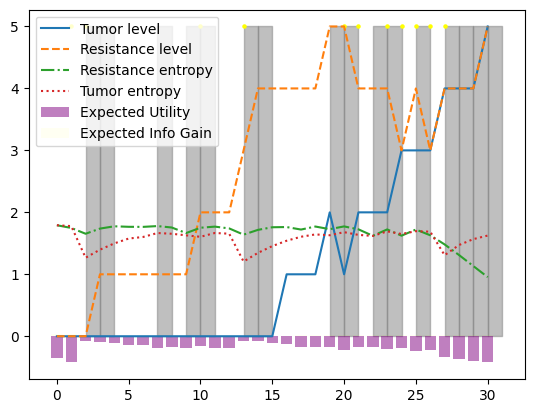

testing_state
not testing    20
testing        11
Name: count, dtype: int64


In [ ]:
#plot the tumor state and resistance state
df = df_single_trial_full_data

plt.plot(df['tumor_state'], label = 'Tumor level') 
plt.plot(df['resistance_state'], label = 'Resistance level', linestyle = '--')

#plot the entropy of resistance beliefs
plt.plot(df_single_trial_full_data['resistance_entropy'], label = 'Resistance entropy', linestyle = '-.')
#plot the entropy of tumor beliefs
plt.plot(df_single_trial_full_data['tumor_entropy'], label = 'Tumor entropy', linestyle = ':')

#shade in when treatment is on
for i in range(len(df_single_trial_full_data)):
    if df_single_trial_full_data['treatment_state'][i] == 'treat':
        plt.fill_between(x = [i, i+1], y1 = 0, y2 = 5, color = 'gray', alpha = 0.5)

#plot in a dot each time testing_state is testing
for i in range(len(df_single_trial_full_data)):
    if df_single_trial_full_data['testing_state'][i] == "testing":
        plt.scatter(i, 5, color = "yellow", s = 5)


#Add bars at each timepoint for expected utility and expected info gain but rescale them smaller by factor of 10
#Add bars at each timepoint for expected utility and expected info gain
plt.bar(range(len(df_single_trial_full_data)), df_single_trial_full_data['expected_utility'] * 0.01, alpha = 0.5, label = 'Expected Utility', color = 'purple')
plt.bar(range(len(df_single_trial_full_data)), df_single_trial_full_data['expected_info_gain'] * 0.01, alpha = 0.05, label = 'Expected Info Gain', color = 'yellow')

#show the labels
plt.legend()

plt.show()

print(df_single_trial_full_data['testing_state'].value_counts())

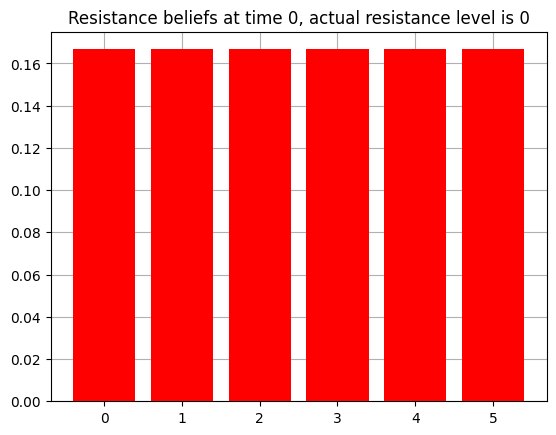

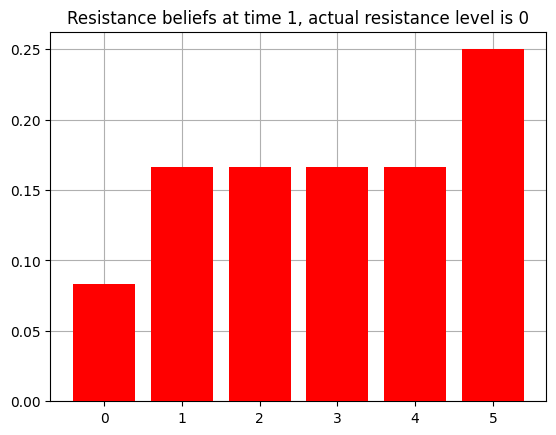

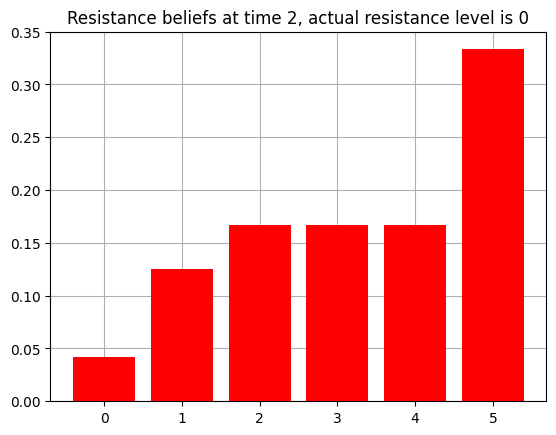

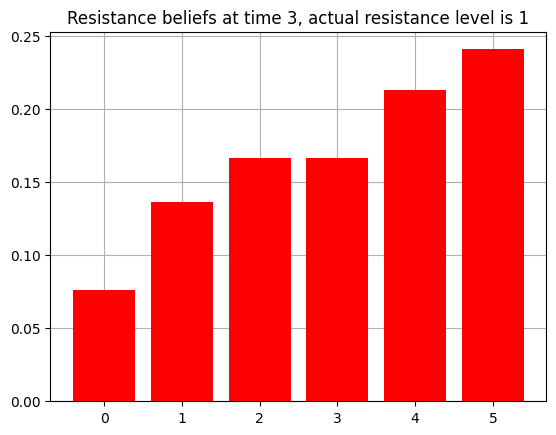

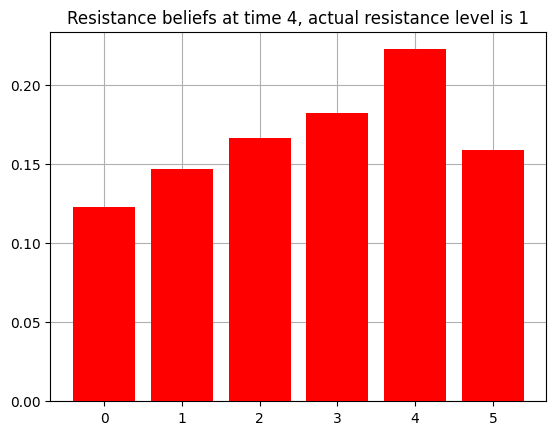

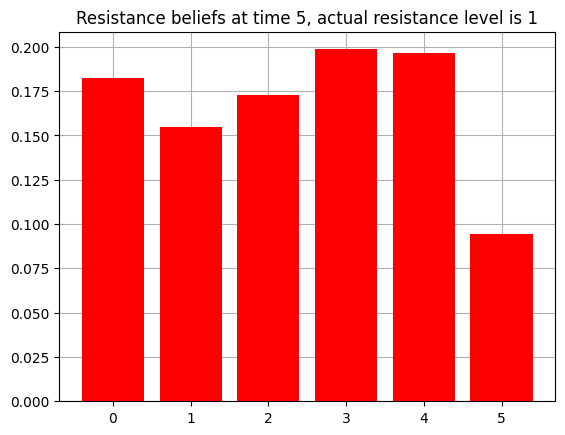

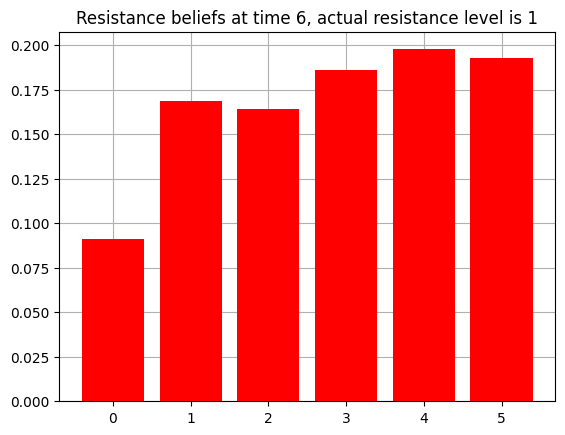

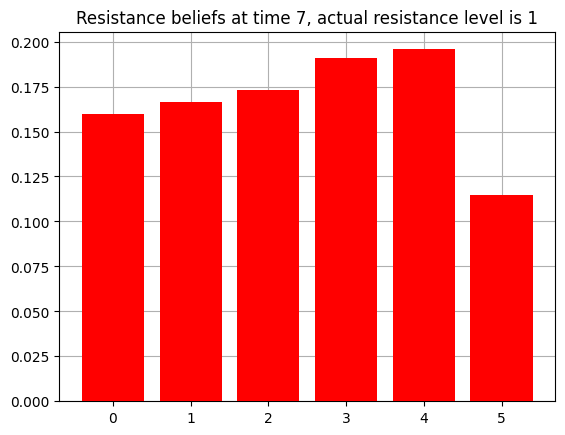

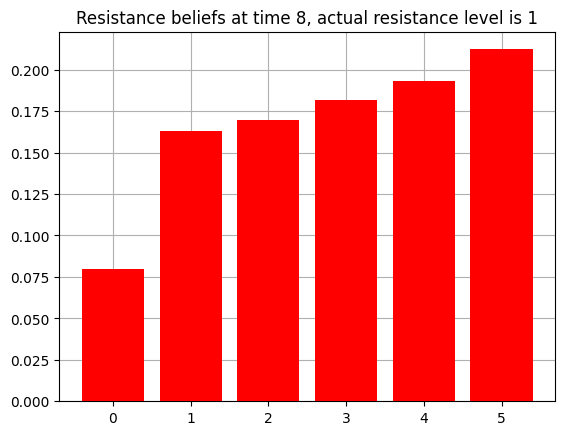

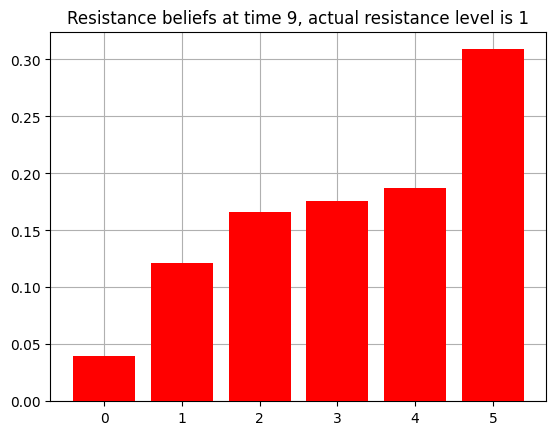

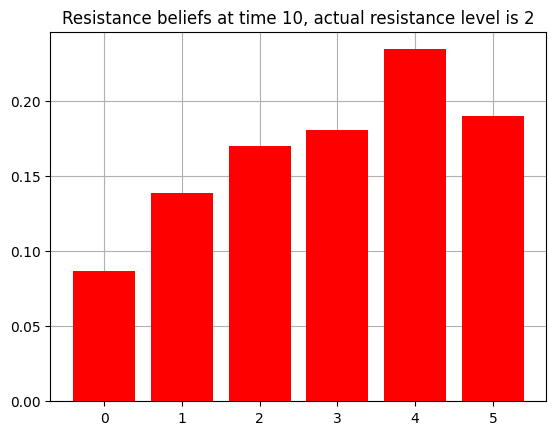

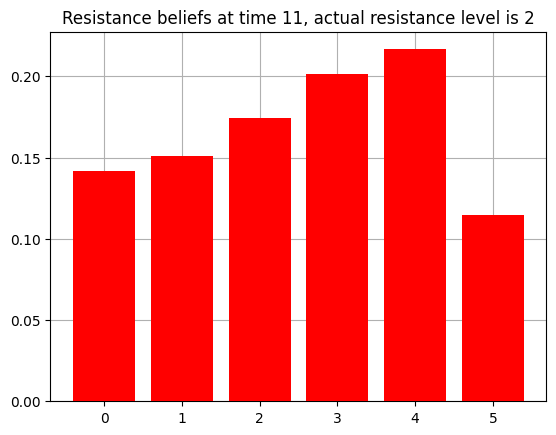

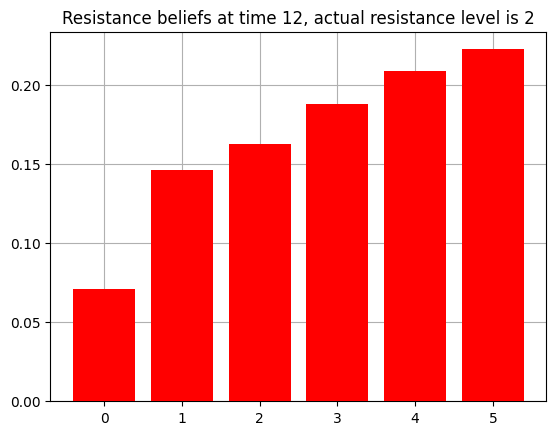

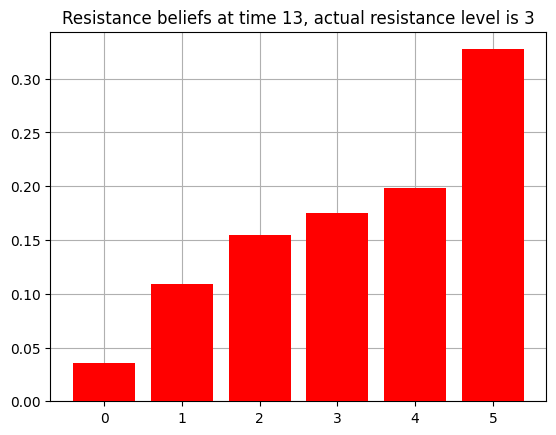

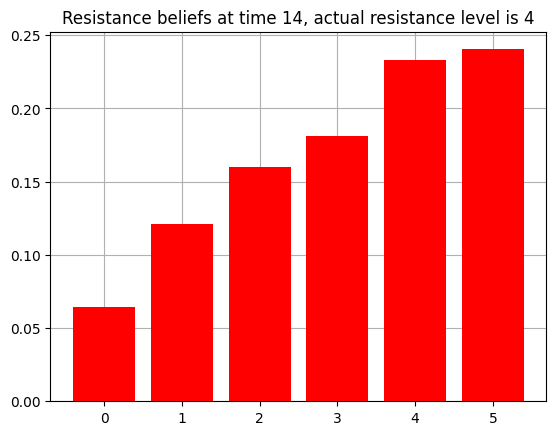

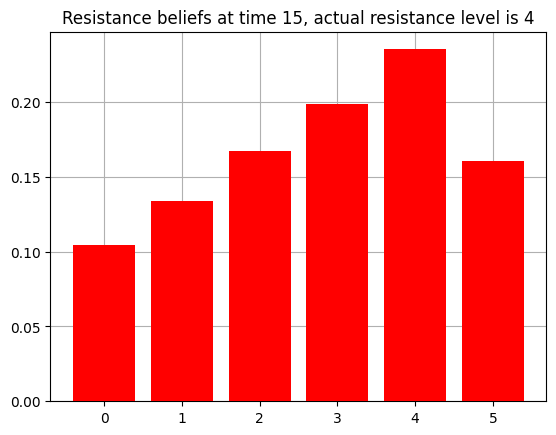

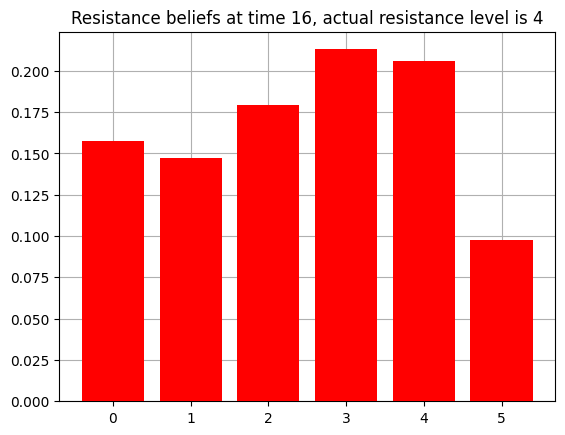

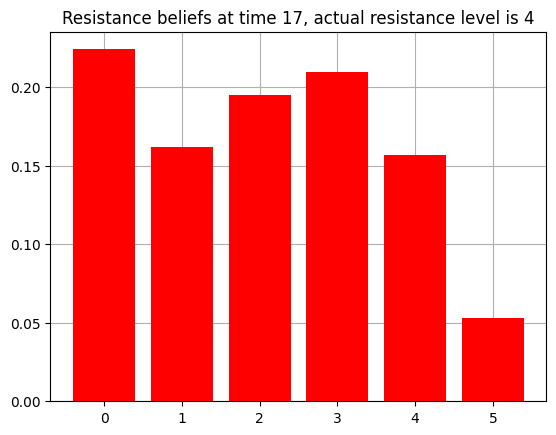

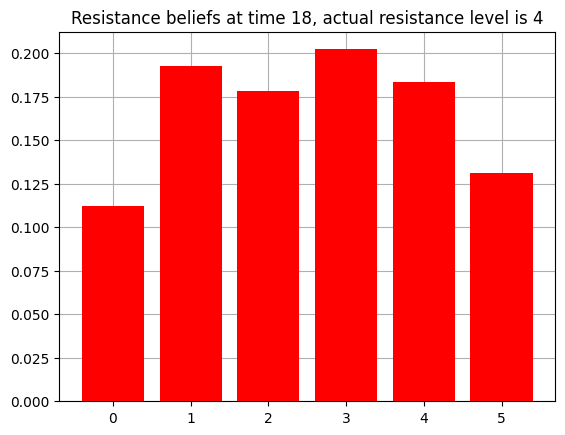

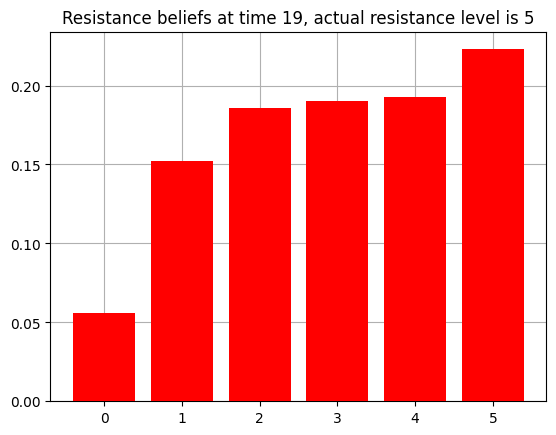

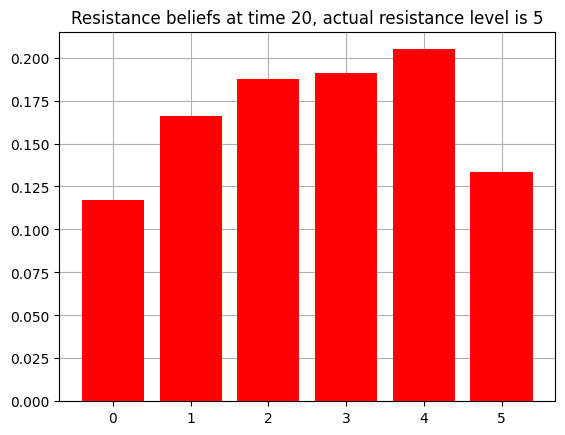

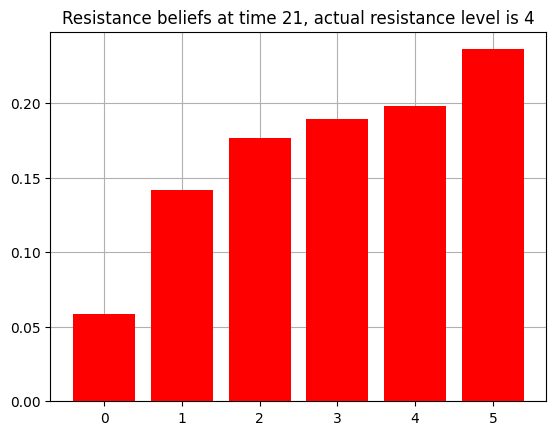

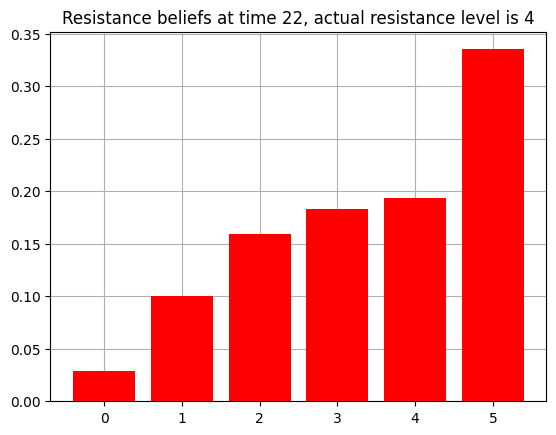

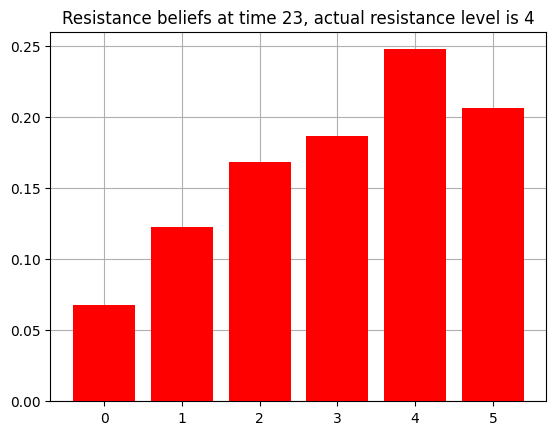

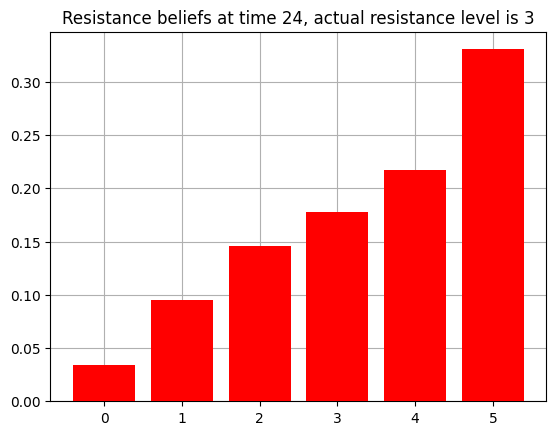

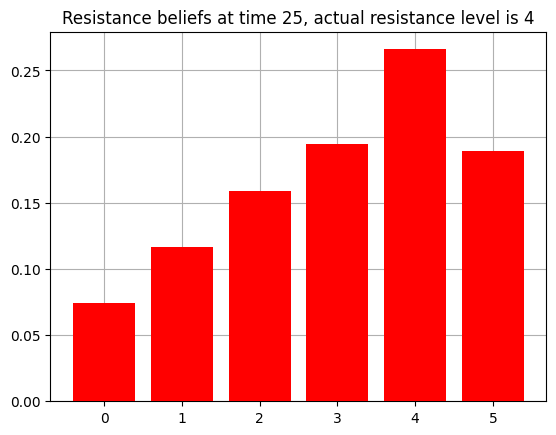

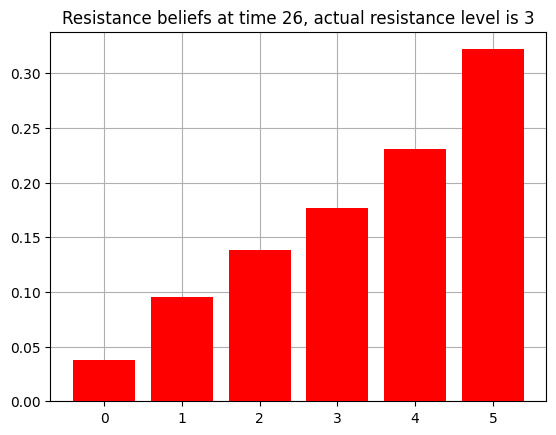

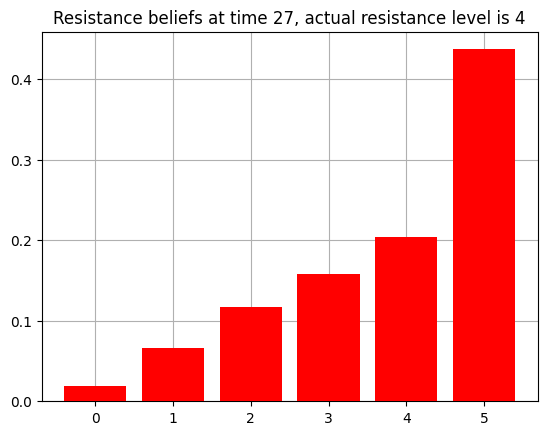

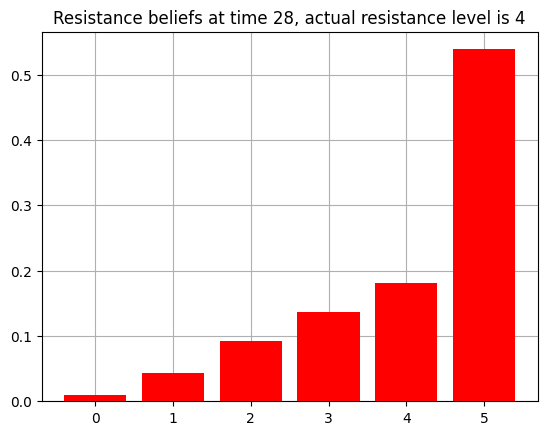

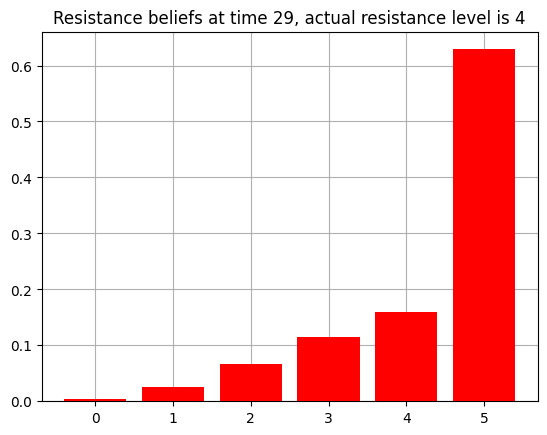

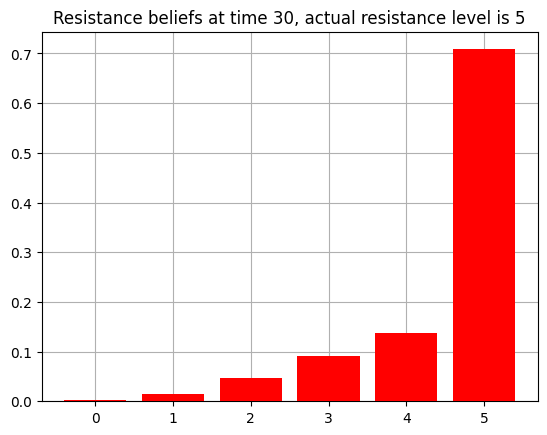

In [ ]:

#iterate through all the rows of df
for index, row, in df_single_trial_full_data.iterrows():
    plot_beliefs(row["resistance_beliefs"], title_str = f"Resistance beliefs at time {index}, actual resistance level is {row['resistance_state']}")

    